In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import scipy as sc
from scipy import stats
import pandas as pd
import pickle
import tqdm

from typing import List, Callable

In [2]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

In [3]:
from rulefit import RuleFit
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
#from category_encoders import JamesSteinEncoder, CatBoostEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import matplotlib.pyplot as plt

In [4]:
data_path =  r"J:\Onderzoek\21-763_rvanes_MiniECG-2-Data\E_ResearchData\2_ResearchData\Analysis"
file_name =  r"input_decision_tree_complete.pkl"

num_splits = 50
num_repeats = 1
USE_CLASS_WEIGHT = True
ALL_FEATURES = True
ALL_FEATURES_STRING = "_useAllvars" if ALL_FEATURES else ""
CLASS_WEIGHT_STRING = "_withClassWeights" if USE_CLASS_WEIGHT else ""

In [5]:
with open(os.path.join(data_path, file_name), 'rb') as f:
    input_decision_tree_complete = pickle.load(f)

In [6]:
DATA = pd.DataFrame(input_decision_tree_complete).T

In [7]:
morphology_columns = [c for c in DATA.columns if 'morphology' in c]
for c in morphology_columns:
    DATA.loc[:, c] = DATA[c].apply(lambda x: x[0].strip(",").strip(" "))
    DATA.loc[:, c] = DATA[c].apply(lambda x: x if x.strip()!="" else "none")

In [8]:
morphology_values = []
for c in morphology_columns:
    morphology_values.extend(DATA[c].unique().tolist())
morphology_values = list(set(morphology_values))

# Model prepping

In [12]:
# TODO: need to sample weights
# TODO: need to reduce the morphology features
impute_kwargs = {
    'estimator': LinearRegression(), 
    'random_state':7,
    'imputation_order': 'ascending', 
    'skip_complete': False,
    'max_iter': 250,
    'initial_strategy': 'median',
    'add_indicator': True
}
gradientboosting_kwargs = {
    'n_estimators': 500, 
    'max_depth': 10, 
    'learning_rate':0.01,
    'max_leaf_nodes':40,
    'random_state': 7
}
randomforest_kwargs = {
    'n_estimators': 100,
    'max_depth': 6,
    'min_samples_split': 2, 
    'min_samples_leaf': 1,
    'random_state': 7
}
rulefit_kwargs={
    'tree_size': 10,
    'max_rules': 100,
    'tree_generator': GradientBoostingClassifier(**gradientboosting_kwargs)
}
decisiontree_kwargs = {
    'criterion':'gini', 
    'splitter':'best', 
    'max_depth':7, 
    'min_samples_split':10, 
    'min_samples_leaf': 5, 
    'min_weight_fraction_leaf':0.0, 
    'max_features':None, 
    'random_state':7, 
    'max_leaf_nodes':40,
    'class_weight': 'balanced'
}
xgboost_kwargs = {
    'n_estimators': 150,
    'max_depth': 5,
    'max_leaves': 50,
    'learning_rate': 2e-3,
    'gamma': 0.4,
    'subsample': 0.55,
    'colsample_bytree':0.85,
    'reg_alpha': 0.005
    }

In [13]:
def training_loop(X, Y, Splitter, PipeDict, use_class_weights=True):
    RES_LIST = []
    
    le_pipe_rf = PipeDict['rf']
    le_pipe_gbc = PipeDict['gbc']
    le_pipe_xgb = PipeDict['xgb']
    le_pipe_dt = PipeDict['dt']
        
    for i, (train_index, test_index) in tqdm.tqdm(enumerate(Splitter.split(X,Y)), total=num_splits*num_repeats):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        if use_class_weights==True:
            WeightMap = dict(zip(np.unique(Y_train), np.bincount(Y_train)))
            VectorizedMapping = np.vectorize(WeightMap.get)
            class_counts = 1000/VectorizedMapping(Y_train)
        else:
            class_counts = None
        # Train models
        le_pipe_rf.fit(X_train, Y_train, RandomForest__sample_weight=class_counts)
        le_pipe_gbc.fit(X_train, Y_train, GradientBoosting__sample_weight=class_counts)
        le_pipe_xgb.fit(X_train, Y_train, XGBoost__sample_weight=class_counts)
        le_pipe_dt.fit(X_train, Y_train, DecisionTree__sample_weight=class_counts)
    
        # Predict on test set
        Y_pred_rf = le_pipe_rf.predict_proba(X_test)
        Y_pred_gbc = le_pipe_gbc.predict_proba(X_test)
        Y_pred_xgb = le_pipe_xgb.predict_proba(X_test)
        Y_pred_dt = le_pipe_dt.predict_proba(X_test)
        
        RES_LIST.append(
            {
                'Y_test': Y_test,
                'Y_pred_rf': Y_pred_rf,
                'Y_pred_gbc': Y_pred_gbc,
                'Y_pred_xgb': Y_pred_xgb,
                'Y_pred_dt': Y_pred_dt,
                'Fold': i%num_splits,
                'Repeat': i//num_splits,            
            }        
        )
    return RES_LIST

In [19]:
def make_plots(results, labelcoder, n_classes, colors, ClassMap):
    plots = []
    
    for i in range(n_classes):
        fig, ax = plt.subplots()
        mean_fpr = np.linspace(0, 1, 100)
        
        tprs_rf = []
        tprs_gbc = []
        tprs_xgb = []
        tprs_dt = []
        aucs_rf = []
        aucs_gbc = []
        aucs_xgb = []
        aucs_dt = []
        
        for res in results:
            y_test_bin = labelcoder.transform(res['Y_test'])
            
            fpr_rf, tpr_rf, _ = roc_curve(y_test_bin[:, i], res['Y_pred_rf'][:, i])
            fpr_gbc, tpr_gbc, _ = roc_curve(y_test_bin[:, i], res['Y_pred_gbc'][:, i])
            fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin[:, i], res['Y_pred_xgb'][:, i])
            fpr_dt, tpr_dt, _ = roc_curve(y_test_bin[:, i], res['Y_pred_dt'][:, i])
            
            interp_tpr_rf = np.interp(mean_fpr, fpr_rf, tpr_rf)
            interp_tpr_gbc = np.interp(mean_fpr, fpr_gbc, tpr_gbc)
            interp_tpr_xgb = np.interp(mean_fpr, fpr_xgb, tpr_xgb)
            interp_tpr_dt = np.interp(mean_fpr, fpr_dt, tpr_dt)
            
            interp_tpr_rf[0] = 0.0
            interp_tpr_gbc[0] = 0.0
            interp_tpr_xgb[0] = 0.0
            interp_tpr_dt[0] = 0.0
            
            tprs_rf.append(interp_tpr_rf)
            tprs_gbc.append(interp_tpr_gbc)
            tprs_xgb.append(interp_tpr_xgb)
            tprs_dt.append(interp_tpr_dt)
            
            aucs_rf.append(auc(fpr_rf, tpr_rf))
            aucs_gbc.append(auc(fpr_gbc, tpr_gbc))
            aucs_xgb.append(auc(fpr_xgb, tpr_xgb))
            aucs_dt.append(auc(fpr_dt, tpr_dt))
        
        mean_tpr_rf = np.mean(tprs_rf, axis=0)
        mean_tpr_gbc = np.mean(tprs_gbc, axis=0)
        mean_tpr_xgb = np.mean(tprs_xgb, axis=0)
        mean_tpr_dt = np.mean(tprs_dt, axis=0)
        
        mean_tpr_rf[-1] = 1.0
        mean_tpr_gbc[-1] = 1.0
        mean_tpr_xgb[-1] = 1.0
        mean_tpr_dt[-1] = 1.0
        
        mean_auc_rf = auc(mean_fpr, mean_tpr_rf)
        mean_auc_gbc = auc(mean_fpr, mean_tpr_gbc)
        mean_auc_xgb = auc(mean_fpr, mean_tpr_xgb)
        mean_auc_dt = auc(mean_fpr, mean_tpr_dt)
        
        std_tpr_rf = np.std(tprs_rf, axis=0)
        std_tpr_gbc = np.std(tprs_gbc, axis=0)
        std_tpr_xgb = np.std(tprs_xgb, axis=0)
        std_tpr_dt = np.std(tprs_dt, axis=0)
        
        # 95% confidence interval
        ci_tpr_rf = stats.norm.ppf(0.975) * std_tpr_rf / np.sqrt(len(tprs_rf))
        ci_tpr_gbc = stats.norm.ppf(0.975) * std_tpr_gbc / np.sqrt(len(tprs_gbc))
        ci_tpr_xgb = stats.norm.ppf(0.975) * std_tpr_xgb/ np.sqrt(len(tprs_xgb))
        ci_tpr_dt = stats.norm.ppf(0.975) * std_tpr_dt / np.sqrt(len(tprs_dt))
        
        ax.plot(mean_fpr, mean_tpr_rf, color=colors[0], lw=2, label=f'Random Forest (mean AUC = {mean_auc_rf:0.2f})')
        ax.fill_between(mean_fpr, mean_tpr_rf - ci_tpr_rf, mean_tpr_rf + ci_tpr_rf, color=colors[0], alpha=0.2)
        
        ax.plot(mean_fpr, mean_tpr_gbc, color=colors[1], lw=2, label=f'Gradient Boosting (mean AUC = {mean_auc_gbc:0.2f})')
        ax.fill_between(mean_fpr, mean_tpr_gbc - ci_tpr_gbc, mean_tpr_gbc + ci_tpr_gbc, color=colors[1], alpha=0.2)
        
        ax.plot(mean_fpr, mean_tpr_xgb, color=colors[1], lw=2, label=f'XGBoosting (mean AUC = {mean_auc_xgb:0.2f})')
        ax.fill_between(mean_fpr, mean_tpr_xgb - ci_tpr_xgb, mean_tpr_xgb + ci_tpr_xgb, color=colors[1], alpha=0.2)
        
        ax.plot(mean_fpr, mean_tpr_dt, color=colors[2], lw=2, label=f'Decision Tree (mean AUC = {mean_auc_dt:0.2f})')
        ax.fill_between(mean_fpr, mean_tpr_dt - ci_tpr_dt, mean_tpr_dt + ci_tpr_dt, color=colors[2], alpha=0.2)
        
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curve for Class {ClassMap[i]}')
        ax.legend(loc="lower right")
        
        plots.append(fig)
        
    return plots

In [15]:
def get_performance(results: List=None, threshold: float=0.5, ClassMap: dict=None, binarizer: Callable=None):
    perf_list = []
    SPEC = lambda tn, fp: tn/(tn+fp)
    for res in results:
        Y_test_bin = binarizer.transform(res['Y_test'])
        Y_pred_rf = res['Y_pred_rf']
        Y_pred_gbt = res['Y_pred_gbc']
        Y_pred_xgb = res['Y_pred_xgb']
        Y_pred_dt = res['Y_pred_dt']
        
        for i in range(n_classes):
            cm = confusion_matrix(Y_test_bin[:,i], np.where(Y_pred_rf[:,i]>threshold, 1, 0))
            tn = cm[0,0]
            tp = cm[1,1]
            fn = cm[1,0]
            fp = cm[0,1]        
            res_dict = {
                'f1': f1_score(Y_test_bin[:,i], np.where(Y_pred_rf[:,i]>threshold, 1, 0)),
                'precision': precision_score(Y_test_bin[:,i], np.where(Y_pred_rf[:,i]>threshold, 1, 0)),
                'recall': recall_score(Y_test_bin[:,i], np.where(Y_pred_rf[:,i]>threshold, 1, 0)),
                'specificity': SPEC(fn, fp),
                'tn': tn,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'model': 'RF',
                'Class': ClassMap[i],
                'Fold': res['Fold'],
                'Repeat': res['Repeat']
            }
            perf_list.append(res_dict)
            
            cm = confusion_matrix(Y_test_bin[:,i], np.where(Y_pred_gbt[:,i]>threshold, 1, 0))
            tn = cm[0,0]
            tp = cm[1,1]
            fn = cm[1,0]
            fp = cm[0,1]          
            res_dict = {
                'f1': f1_score(Y_test_bin[:,i], np.where(Y_pred_gbt[:,i]>threshold, 1, 0)),
                'precision': precision_score(Y_test_bin[:,i], np.where(Y_pred_gbt[:,i]>threshold, 1, 0)),
                'recall': recall_score(Y_test_bin[:,i], np.where(Y_pred_gbt[:,i]>threshold, 1, 0)),
                'specificity': SPEC(fn, fp),
                'tn': tn,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'model': 'GBT',
                'Class': ClassMap[i],
                'Fold': res['Fold'],
                'Repeat': res['Repeat']
            }
            perf_list.append(res_dict)
            
            cm = confusion_matrix(Y_test_bin[:,i], np.where(Y_pred_xgb[:,i]>threshold, 1, 0))
            tn = cm[0,0]
            tp = cm[1,1]
            fn = cm[1,0]
            fp = cm[0,1]          
            res_dict = {
                'f1': f1_score(Y_test_bin[:,i], np.where(Y_pred_xgb[:,i]>threshold, 1, 0)),
                'precision': precision_score(Y_test_bin[:,i], np.where(Y_pred_xgb[:,i]>threshold, 1, 0)),
                'recall': recall_score(Y_test_bin[:,i], np.where(Y_pred_xgb[:,i]>threshold, 1, 0)),
                'specificity': SPEC(fn, fp),
                'tn': tn,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'model': 'XGB',
                'Class': ClassMap[i],
                'Fold': res['Fold'],
                'Repeat': res['Repeat']
            }
            perf_list.append(res_dict)
            
            cm = confusion_matrix(Y_test_bin[:,i], np.where(Y_pred_rf[:,i]>threshold, 1, 0))
            tn = cm[0,0]
            tp = cm[1,1]
            fn = cm[1,0]
            fp = cm[0,1] 
            res_dict = {
                'f1': f1_score(Y_test_bin[:,i], np.where(Y_pred_dt[:,i]>threshold, 1, 0)),
                'precision': precision_score(Y_test_bin[:,i], np.where(Y_pred_dt[:,i]>threshold, 1, 0)),
                'recall': recall_score(Y_test_bin[:,i], np.where(Y_pred_dt[:,i]>threshold, 1, 0)),
                'specificity': SPEC(fn, fp),
                'tn': tn,
                'tp': tp,
                'fn': fn,
                'fp': fp,
                'model': 'DT',
                'Class': ClassMap[i],
                'Fold': res['Fold'],
                'Repeat': res['Repeat']
            }
            perf_list.append(res_dict)
    return perf_list

# Axis model

In [12]:
target_col = "Heart Axis Diagnosis"
target_inclusion = ['Left', 'Normal', 'Right']
if ALL_FEATURES:
    features_to_use = []
else:
    features_to_use = ['qrs_vector mean lead_0',
                     'p_vector mean lead_0',
                     't_vector mean lead_0',
                     'qrs_vector mean lead_1',
                     'p_vector mean lead_1',
                     't_vector mean lead_1',
                     'qrs_vector mean lead_2',
                     'p_vector mean lead_2',
                     't_vector mean lead_2',
                     'qrs_vector mean lead_3',
                     'p_vector mean lead_3',
                     't_vector mean lead_3',
                     'qrs_vector mean lead_4',
                     'p_vector mean lead_4',
                     't_vector mean lead_4',
                     'qrs_vector mean lead_5',
                     'p_vector mean lead_5',
                     't_vector mean lead_5',
                     'qrs_vector mean lead_6',
                     'p_vector mean lead_6',
                     't_vector mean lead_6',
                     'qrs_vector mean lead_7',
                     'p_vector mean lead_7',
                     't_vector mean lead_7'
                       ]

In [13]:
if len(features_to_use)==0:
    meas_cols = [c for c in DATA.columns if ('Dataset' not in c) & (target_col not in c)]
else:
    meas_cols = features_to_use
AXIS_DATA = DATA.loc[DATA[target_col].isin(target_inclusion), meas_cols+[target_col]+['Dataset']]
AXIS_DATA.to_parquet(os.path.join(data_path, f'AXIS_DATA{ALL_FEATURES_STRING}.parquet'))
AXIS_DATA = AXIS_DATA.drop('Dataset', axis=1)

### TRAINING LOOP

In [14]:
OrdEncoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)
PipeOrdEncoder = ColumnTransformer([("cat_encoder", OrdEncoder, morphology_columns)], remainder='passthrough')
#
if ALL_FEATURES:
    _cat_enc = PipeOrdEncoder
else:
    _cat_enc = None
    
le_pipe_rf = Pipeline([
    ("CatEncoder", _cat_enc),
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("RandomForest", RandomForestClassifier(**randomforest_kwargs))])

le_pipe_gbc = Pipeline([
    ("CatEncoder", _cat_enc),
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("GradientBoosting", GradientBoostingClassifier(**gradientboosting_kwargs))])

le_pipe_xgb = Pipeline([
    ("CatEncoder", _cat_enc),
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("XGBoost", XGBClassifier(**xgboost_kwargs))])

le_pipe_dt = Pipeline([
    ("CatEncoder", _cat_enc),
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("DecisionTree", DecisionTreeClassifier(**decisiontree_kwargs))])

PipeDict = {
    'rf': le_pipe_rf,
    'gbc': le_pipe_gbc,
    'xgb': le_pipe_xgb,
    'dt': le_pipe_dt    
}

In [15]:
splitter = RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=7)

X = AXIS_DATA.iloc[:, :-1]
Y = AXIS_DATA.iloc[:,-1]

lb = LabelBinarizer()
lbe = LabelEncoder()

 #(RES_LIST_AXIS[0]['Y_test'])
Yenc = lbe.fit_transform(Y.values) #(RES_LIST_AXIS[0]['Y_test'])
y_bin = lb.fit(Yenc)
ClassMap_AXIS = {i:c for i,c in enumerate(lbe.classes_)}

In [16]:
ClassMap_AXIS

{0: 'Left', 1: 'Normal', 2: 'Right'}

In [17]:
RES_LIST_AXIS = training_loop(X, Yenc, splitter, PipeDict, use_class_weights=USE_CLASS_WEIGHT)

100%|██████████| 100/100 [2:47:59<00:00, 100.80s/it] 


### make roc and precision recall curves

In [18]:
Y.value_counts()

Heart Axis Diagnosis
Normal    1245
Left       377
Right       73
Name: count, dtype: int64

In [19]:
n_classes = len(lb.classes_)
colors = ['blue', 'green', 'red', 'yellow']

D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classificati

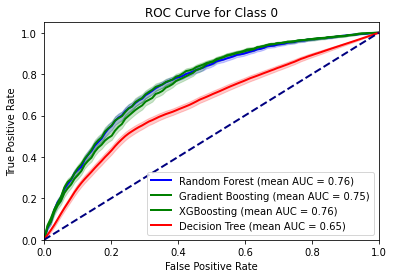

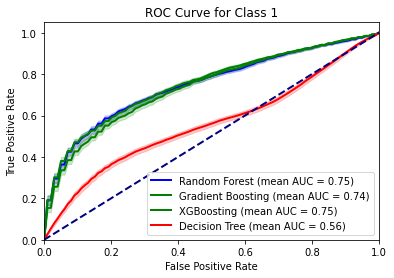

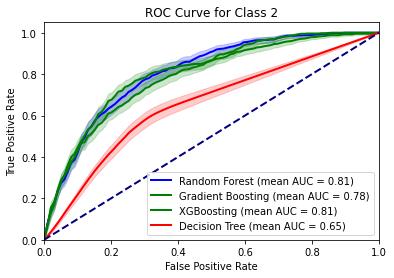

In [20]:
PLOTS_AXIS = make_plots(RES_LIST_AXIS, lb,  n_classes, colors, ClassMap_AXIS)
perf_list = get_performance(RES_LIST_AXIS, threshold=0.5, ClassMap=ClassMap_AXIS, binarizer=lb)
PERF_AXIS = pd.DataFrame(perf_list)
PERF_AXIS.to_parquet(os.path.join(data_path, f"AXIS_perf{CLASS_WEIGHT_STRING}{ALL_FEATURES_STRING}.parquet"))

# Muscle model

In [21]:
target_col = "Diagnosis"
target_inclusion = ['SR','LVH','Microvoltages']
if ALL_FEATURES:
    features_to_use = []
else:
    features_to_use = ['qrs_vector mean lead_0',
                     'qrs_ampl mean lead_0',
                     'qrs_vector mean lead_1',
                     'qrs_ampl mean lead_1',
                     'qrs_vector mean lead_2',
                     'qrs_ampl mean lead_2',
                     'qrs_vector mean lead_3',
                     'qrs_ampl mean lead_3',
                     'qrs_vector mean lead_4',
                     'qrs_ampl mean lead_4',
                     'qrs_vector mean lead_5',
                     'qrs_ampl mean lead_5',
                     'qrs_vector mean lead_6',
                     'qrs_ampl mean lead_6',
                     'qrs_vector mean lead_7',
                     'qrs_ampl mean lead_7',
                     'morphology lead_0',
                     'morphology lead_1',
                     'morphology lead_2',
                     'morphology lead_3',
                     'morphology lead_4',
                     'morphology lead_5',
                     'morphology lead_6',
                     'morphology lead_7']

In [22]:
if len(features_to_use)==0:
    meas_cols = [c for c in DATA.columns if ('Dataset' not in c) & (target_col not in c)]
else:
    meas_cols = features_to_use
MUSCLE_DATA = DATA.loc[DATA[target_col].apply(lambda x: any([c in x for c in target_inclusion])), 
                       meas_cols+[target_col]+['Dataset']]
MUSCLE_DATA.to_parquet(os.path.join(data_path, f'MUSCLE_DATA{ALL_FEATURES_STRING}.parquet'))
MUSCLE_DATA = MUSCLE_DATA.drop('Dataset', axis=1)

In [23]:
MUSCLE_DATA = MUSCLE_DATA.assign(Diagnosis=MUSCLE_DATA.Diagnosis.map({
                                                            'SR': 'SR',
                                                            'Microvoltages': 'Microvoltages',
                                                            'LVH': 'LVH',
                                                            'LAFB , LVH': 'LVH',
                                                            'Microvoltages , BF': 'Microvoltages',
                                                            'Microvoltages , RBBB': 'Microvoltages',
                                                            'Microvoltages , LAFB': 'Microvoltages',
                                                            'LVH , BF': 'LVH',
                                                            'LVH , RBBB': 'LVH',
                                                            'LVH , LBBB': 'LVH'
                                                        }))

## Training loop

In [24]:
OrdEncoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)
PipeOrdEncoder = ColumnTransformer([("cat_encoder", OrdEncoder, morphology_columns)], remainder='passthrough')
le_pipe_rf = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("RandomForest", RandomForestClassifier(**randomforest_kwargs))])
le_pipe_gbc = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("GradientBoosting", GradientBoostingClassifier(**gradientboosting_kwargs))])
le_pipe_xgb = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("XGBoost", XGBClassifier(**xgboost_kwargs))])
le_pipe_dt = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("DecisionTree", DecisionTreeClassifier(**decisiontree_kwargs))])

PipeDict = {
    'rf': le_pipe_rf,
    'gbc': le_pipe_gbc,
    'xgb': le_pipe_xgb,
    'dt': le_pipe_dt    
}

In [25]:
splitter = RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=7)
X = MUSCLE_DATA.iloc[:, :-1]
Y = MUSCLE_DATA.iloc[:,-1]

lb = LabelBinarizer()
lbe = LabelEncoder()
 #(RES_LIST_AXIS[0]['Y_test'])
Yenc = lbe.fit_transform(Y.values) #(RES_LIST_AXIS[0]['Y_test'])
lb.fit(Yenc)
ClassMap_MUSCLE = {i:c for i,c in enumerate(lbe.classes_)}

In [26]:
RES_LIST_MUSCLE = training_loop(X, Yenc, splitter, PipeDict, use_class_weights=USE_CLASS_WEIGHT)

100%|██████████| 100/100 [1:32:36<00:00, 55.57s/it]


### make roc and precision recall curves

In [27]:
Y.value_counts()

Diagnosis
SR               649
Microvoltages    215
LVH              198
Name: count, dtype: int64

In [28]:
n_classes = len(lb.classes_)
colors = ['blue', 'green', 'red']

D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\VENVS\Envs\base_310\lib\site-packages\sklearn\metrics\_classificati

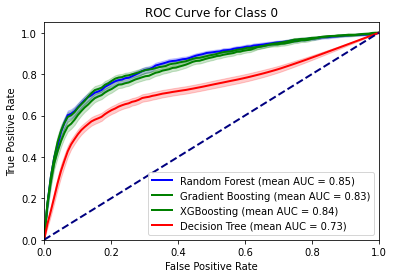

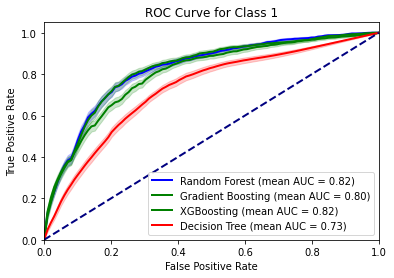

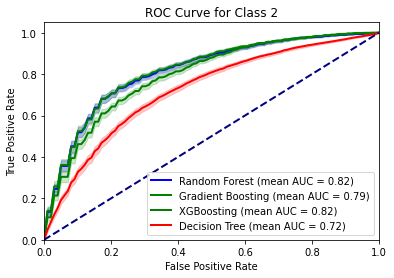

In [29]:
PLOTS_MUSCLE = make_plots(RES_LIST_MUSCLE, lb,  n_classes, colors, ClassMap_MUSCLE)
perf_list = get_performance(RES_LIST_MUSCLE, threshold=0.5, ClassMap=ClassMap_MUSCLE, binarizer=lb)
PERF_MUSCLE = pd.DataFrame(perf_list)
PERF_MUSCLE.to_parquet(os.path.join(data_path, f"MUSCLE_perf{CLASS_WEIGHT_STRING}{ALL_FEATURES_STRING}.parquet"))

# Conduction model

In [16]:
target_col = "Diagnosis"
target_inclusion = ['BF', 'LBBB','RBBB','LAFB', 'SR']
features_to_use = []

In [17]:
if len(features_to_use)==0:
    meas_cols = [c for c in DATA.columns if ('Dataset' not in c) & (target_col not in c)]
else:
    meas_cols = features_to_use
CONDUCTION_DATA = DATA.loc[DATA[target_col].apply(lambda x: any([c in x for c in target_inclusion])), 
                       meas_cols+[target_col]+['Dataset']]
CONDUCTION_DATA.to_parquet(os.path.join(data_path, f'CONDUCTION_DATA{ALL_FEATURES_STRING}.parquet'))
CONDUCTION_DATA = CONDUCTION_DATA.drop('Dataset', axis=1)

In [18]:
# ['BF', 'LBBB','RBBB','LAFB', 'SR']
CONDUCTION_DATA = CONDUCTION_DATA.assign(Diagnosis=CONDUCTION_DATA.Diagnosis.map({
                                                                'SR': 'SR',
                                                                'BF': 'BF',
                                                                'RBBB': 'RBBB',
                                                                'LBBB': 'LBBB',
                                                                'LAFB': 'LAFB',
                                                                'LAFB , LVH': 'LAFB',
                                                                'Microvoltages , BF': 'BF',
                                                                'Microvoltages , RBBB': 'RBBB',
                                                                'Microvoltages , LAFB': 'LAFB', 
                                                                'LVH , BF': 'BF',
                                                                'LVH , RBBB': 'RBBB',
                                                                'LVH , LBBB': 'LBBB'
                                                            }))

## Training loop

In [19]:
OrdEncoder = OrdinalEncoder(
    categories='auto',
    dtype=int,
    handle_unknown='use_encoded_value',
    unknown_value=-2,
    encoded_missing_value=-1,
)
PipeOrdEncoder = ColumnTransformer([("cat_encoder", OrdEncoder, morphology_columns)], remainder='passthrough')
le_pipe_rf = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("RandomForest", RandomForestClassifier(**randomforest_kwargs))])
le_pipe_gbc = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("GradientBoosting", GradientBoostingClassifier(**gradientboosting_kwargs))])
le_pipe_xgb = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("XGBoost", XGBClassifier(**xgboost_kwargs))])
le_pipe_dt = Pipeline([
    ("CatEncoder", PipeOrdEncoder), 
    ("Impute", IterativeImputer(**impute_kwargs)),
    ("DecisionTree", DecisionTreeClassifier(**decisiontree_kwargs))])

PipeDict = {
    'rf': le_pipe_rf,
    'gbc': le_pipe_gbc,
    'xgb': le_pipe_xgb,
    'dt': le_pipe_dt    
}

In [29]:
splitter = RepeatedStratifiedKFold(n_splits=num_splits, n_repeats=num_repeats, random_state=7)
X = CONDUCTION_DATA.iloc[:, :-1]
Y = CONDUCTION_DATA.iloc[:,-1]

lb = LabelBinarizer()
lbe = LabelEncoder()
Yenc = lbe.fit_transform(Y)
lb.fit(Yenc)    
ClassMap_CONDUCTION = {i:c for i,c in enumerate(lbe.classes_)}

In [30]:
ClassMap_CONDUCTION

{0: 'BF', 1: 'LAFB', 2: 'LBBB', 3: 'RBBB', 4: 'SR'}

In [31]:
RES_LIST_CONDUCTION = training_loop(X, Yenc, splitter, PipeDict, use_class_weights=USE_CLASS_WEIGHT)

 12%|█▏        | 12/100 [31:11<3:48:45, 155.97s/it]


KeyboardInterrupt: 

### make roc and precision recall curves

In [ ]:
Y.value_counts()

In [ ]:
n_classes = len(lb.classes_)
colors = ['blue', 'green', 'red', 'yellow']

In [ ]:
PLOTS_CONDUCTION = make_plots(RES_LIST_CONDUCTION, lb,  n_classes, colors, ClassMap_CONDUCTION)
perf_list = get_performance(RES_LIST_CONDUCTION, threshold=0.5, ClassMap=ClassMap_CONDUCTION, binarizer=lb)
PERF_CONDUCTION = pd.DataFrame(perf_list)
PERF_CONDUCTION.to_parquet(os.path.join(data_path, f"CONDUCTION_perf{CLASS_WEIGHT_STRING}{ALL_FEATURES_STRING}.parquet"))